In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import re
import matplotlib.pyplot as plt

spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

### Read data

In [38]:
def read_dataset(spark, path):
    try:
        df= spark.read.format("csv").option("header", True).option("inferSchema", True).option("multiLine", True).option("escape", '"').load(path)
        return df
    except Exception as e:
        print("Error reading dataset")
        raise

file_path="C:\\Users\\sakumarchoudhary\\github\\data_engineering_takehome1\\dataset\\nyc-jobs.csv"
df_raw = read_dataset(spark, file_path)

In [5]:
df_raw.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

In [8]:
spark.version

'3.5.2'

In [9]:
spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()

'3.3.4'

In [8]:
#null analysis

def null_analysis(df):
    df_null= df.select([
        count(when(col(c).isNull(), c)).alias(c)
        for c in df.columns
    ])

    return df_null

In [9]:
df_null=null_analysis(df_raw)
df_null.show()

+------+------+------------+--------------+--------------+-------------------+-------------+-----+------------+-----------------------------+-----------------+---------------+----------------+-------------+------------------+---------------+-------------------------+----------------+----------------------+--------+-----------+---------------+-------------------+---------------------+------------+----------+---------------+------------+
|Job ID|Agency|Posting Type|# Of Positions|Business Title|Civil Service Title|Title Code No|Level|Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|Work Location|Division/Work Unit|Job Description|Minimum Qual Requirements|Preferred Skills|Additional Information|To Apply|Hours/Shift|Work Location 1|Recruitment Contact|Residency Requirement|Posting Date|Post Until|Posting Updated|Process Date|
+------+------+------------+--------------+--------------+-------------------+-------------+-----+------------+---------

In [48]:
def standardize_column_names(df):
    try:
        new_columns = []
        for col_name in df.columns:
            col_clean = col_name.strip().lower()
            col_clean = re.sub(r"[^\w]+", "_", col_clean)
            col_clean = re.sub(r"_+", "_", col_clean)
            col_clean = col_clean.strip("_")
            new_columns.append(col_clean)
        return df.toDF(*new_columns)

    except Exception as e:
        print("Error while standasdizing column names")
        raise

df = standardize_column_names(df_raw)

In [40]:
df.printSchema()

root
 |-- job_id: integer (nullable = true)
 |-- agency: string (nullable = true)
 |-- posting_type: string (nullable = true)
 |-- of_positions: integer (nullable = true)
 |-- business_title: string (nullable = true)
 |-- civil_service_title: string (nullable = true)
 |-- title_code_no: string (nullable = true)
 |-- level: string (nullable = true)
 |-- job_category: string (nullable = true)
 |-- full_time_part_time_indicator: string (nullable = true)
 |-- salary_range_from: double (nullable = true)
 |-- salary_range_to: double (nullable = true)
 |-- salary_frequency: string (nullable = true)
 |-- work_location: string (nullable = true)
 |-- division_work_unit: string (nullable = true)
 |-- job_description: string (nullable = true)
 |-- minimum_qual_requirements: string (nullable = true)
 |-- preferred_skills: string (nullable = true)
 |-- additional_information: string (nullable = true)
 |-- to_apply: string (nullable = true)
 |-- hours_shift: string (nullable = true)
 |-- work_locatio

In [49]:
def categorize_columns(df):
    # 3. Identify and print numerical and categorical columns
    numerical_cols = []
    categorical_cols = []
    
    for field in df.schema:
        if isinstance(field.dataType, (IntegerType, DoubleType, FloatType, LongType, ShortType, ByteType, DecimalType)):
            numerical_cols.append(field.name)
        elif isinstance(field.dataType, StringType):
            categorical_cols.append(field.name)
    
    print(f"\nNumerical Columns: {numerical_cols}")
    print(f"Categorical Columns: {categorical_cols}")

    return numerical_cols, categorical_cols

In [50]:
numerical_cols, categorical_cols=categorize_columns(df)


Numerical Columns: ['job_id', 'of_positions', 'salary_range_from', 'salary_range_to']
Categorical Columns: ['agency', 'posting_type', 'business_title', 'civil_service_title', 'title_code_no', 'level', 'job_category', 'full_time_part_time_indicator', 'salary_frequency', 'work_location', 'division_work_unit', 'job_description', 'minimum_qual_requirements', 'preferred_skills', 'additional_information', 'to_apply', 'hours_shift', 'work_location_1', 'recruitment_contact', 'residency_requirement']


In [52]:
def clean_data(df):
    try:
        # 1. Remove rows where 'Job Category' or 'Full-Time/Part-Time indicator' are null
        df = df.dropna(subset=['job_category', 'full_time_part_time_indicator'])
        
        # 2. For categorical columns, fill any remaining null values with an empty string
        for col_name in categorical_cols:
            df = df.withColumn(col_name, when(col(col_name).isNull(), '').otherwise(col(col_name)))
        
        # 3. Create a new column named `avg_salary`
        df = df.withColumn('avg_salary', (col('salary_range_from') + col('salary_range_to')) / 2)
        
        # 4. Create a new column named `normalized_annual_salary`
        df = df.withColumn('normalized_annual_salary',
                           when(col('salary_frequency') == 'Hourly', col('avg_salary') * 2080)
                           .when(col('salary_frequency') == 'Daily', col('avg_salary') * 260)
                           .when(col('salary_frequency') == 'Annual', col('avg_salary'))
                           .otherwise(None) # Handle any unexpected frequencies
                          )

        df=df.withColumnRenamed('of_positions', 'number_of_positions')
        
        # 5. Print the schema and display the first few rows of the DataFrame
        print("Schema of DataFrame after cleaning and salary processing:")
        df.printSchema()
        
        print("\nFirst 5 rows of DataFrame with new salary columns:")
        df.select('job_id', 'agency', 'salary_range_from', 'salary_range_to', 'salary_frequency', 'avg_salary', 'normalized_annual_salary').show(5)
    
        # Remove duplicates
        df = df.dropDuplicates()
    
        return df
    except Exception as e:
        print("Error while cleaning the dataset")
        raise

df_clean = clean_data(df)

Schema of DataFrame after cleaning and salary processing:
root
 |-- job_id: integer (nullable = true)
 |-- agency: string (nullable = true)
 |-- posting_type: string (nullable = true)
 |-- number_of_positions: integer (nullable = true)
 |-- business_title: string (nullable = true)
 |-- civil_service_title: string (nullable = true)
 |-- title_code_no: string (nullable = true)
 |-- level: string (nullable = true)
 |-- job_category: string (nullable = true)
 |-- full_time_part_time_indicator: string (nullable = true)
 |-- salary_range_from: double (nullable = true)
 |-- salary_range_to: double (nullable = true)
 |-- salary_frequency: string (nullable = true)
 |-- work_location: string (nullable = true)
 |-- division_work_unit: string (nullable = true)
 |-- job_description: string (nullable = true)
 |-- minimum_qual_requirements: string (nullable = true)
 |-- preferred_skills: string (nullable = true)
 |-- additional_information: string (nullable = true)
 |-- to_apply: string (nullable = t

In [53]:
# df_clean.show(n=5)

In [54]:
# df_clean.select('salary_frequency').distinct().show()

In [57]:
#adding feature engineering techniques

def add_features(df):
    
    df = df.withColumn('education_level',
                       when(lower(col('minimum_qual_requirements')).contains('ph.d.'), 'PhD')
                       .when(lower(col('minimum_qual_requirements')).contains('doctorate'), 'PhD')
                       .when(lower(col('minimum_qual_requirements')).contains('master'), 'Master')
                       .when(lower(col('minimum_qual_requirements')).contains('bachelor'), 'Bachelor')
                       .when(lower(col('minimum_qual_requirements')).contains('associate'), 'Associate')
                       .when(lower(col('minimum_qual_requirements')).contains('high school'), 'High School/GED')
                       .when(lower(col('minimum_qual_requirements')).contains('ged'), 'High School/GED')
                       .otherwise('Not Specified')
                      )
    
    # 2. Create a new column named `experience_level`
    df = df.withColumn('experience_level',
                       when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('director'), 'Executive/Director')
                       .when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('chief'), 'Executive/Director')
                       .when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('head'), 'Executive/Director')
                       .when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('vp'), 'Executive/Director')
                       .when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('senior'), 'Senior')
                       .when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('lead'), 'Senior')
                       .when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('manager'), 'Mid-Level')
                       .when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('specialist'), 'Mid-Level')
                       .when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('junior'), 'Entry-Level')
                       .when(lower(concat_ws(' ', col('business_title'), col('job_description'))).contains('entry'), 'Entry-Level')
                       .otherwise('Not Specified')
                      )
    
    # 3. Create three binary indicator columns for specific skills
    df = df.withColumn('has_python',
                       when(lower(col('preferred_skills')).contains('python'), 1).otherwise(0))
    df = df.withColumn('has_sql',
                       when(lower(col('preferred_skills')).contains('sql'), 1).otherwise(0))
    df = df.withColumn('has_cloud',
                       when(lower(col('preferred_skills')).contains('cloud'), 1).otherwise(0))
    
    # 4. Print the updated schema of the DataFrame
    print("Schema of DataFrame after feature engineering:")
    df.printSchema()
    
    # 5. Display selected columns for verification
    print("\nFirst 10 rows with new feature engineered columns:")
    df.select('job_id', 'business_title', 'minimum_qual_requirements', 'preferred_skills',
              'education_level', 'experience_level', 'has_python', 'has_sql', 'has_cloud').show(10, truncate=False)

    return df

df = add_features(df_clean)

Schema of DataFrame after feature engineering:
root
 |-- job_id: integer (nullable = true)
 |-- agency: string (nullable = true)
 |-- posting_type: string (nullable = true)
 |-- number_of_positions: integer (nullable = true)
 |-- business_title: string (nullable = true)
 |-- civil_service_title: string (nullable = true)
 |-- title_code_no: string (nullable = true)
 |-- level: string (nullable = true)
 |-- job_category: string (nullable = true)
 |-- full_time_part_time_indicator: string (nullable = true)
 |-- salary_range_from: double (nullable = true)
 |-- salary_range_to: double (nullable = true)
 |-- salary_frequency: string (nullable = true)
 |-- work_location: string (nullable = true)
 |-- division_work_unit: string (nullable = true)
 |-- job_description: string (nullable = true)
 |-- minimum_qual_requirements: string (nullable = true)
 |-- preferred_skills: string (nullable = true)
 |-- additional_information: string (nullable = true)
 |-- to_apply: string (nullable = true)
 |-- h

In [20]:
# df.select('job_description').distinct().show(n=10, truncate=False)

In [58]:
df.printSchema()

root
 |-- job_id: integer (nullable = true)
 |-- agency: string (nullable = true)
 |-- posting_type: string (nullable = true)
 |-- number_of_positions: integer (nullable = true)
 |-- business_title: string (nullable = true)
 |-- civil_service_title: string (nullable = true)
 |-- title_code_no: string (nullable = true)
 |-- level: string (nullable = true)
 |-- job_category: string (nullable = true)
 |-- full_time_part_time_indicator: string (nullable = true)
 |-- salary_range_from: double (nullable = true)
 |-- salary_range_to: double (nullable = true)
 |-- salary_frequency: string (nullable = true)
 |-- work_location: string (nullable = true)
 |-- division_work_unit: string (nullable = true)
 |-- job_description: string (nullable = true)
 |-- minimum_qual_requirements: string (nullable = true)
 |-- preferred_skills: string (nullable = true)
 |-- additional_information: string (nullable = true)
 |-- to_apply: string (nullable = true)
 |-- hours_shift: string (nullable = true)
 |-- work_

## KPI1 : number of jobs posting per category (Top 10)

In [61]:
# KPI 1: Top 10 Jobs Per Category
def kpi_top_10_categories(df):
    df_top_10_category=df.groupBy("job_category").agg(sum('number_of_positions').alias("job_count")).orderBy(desc("job_count")).limit(10)
    
    return df_top_10_category

In [62]:
top_10_category_df=kpi_top_10_categories(df)
top_10_category_df.show(truncate=False)

+-----------------------------------------+---------+
|job_category                             |job_count|
+-----------------------------------------+---------+
|Building Operations & Maintenance        |1206     |
|Public Safety, Inspections, & Enforcement|1021     |
|Engineering, Architecture, & Planning    |739      |
|Legal Affairs                            |484      |
|Health                                   |352      |
|Technology, Data & Innovation            |343      |
|Administration & Human Resources         |301      |
|Finance, Accounting, & Procurement       |255      |
|Maintenance & Operations                 |210      |
|Policy, Research & Analysis              |196      |
+-----------------------------------------+---------+



In [63]:
kpi1 = top_10_category_df
kpi1.write.mode("overwrite").parquet("C:\\Users\\sakumarchoudhary\\github\\data_engineering_takehome1\\target\\kpi1")

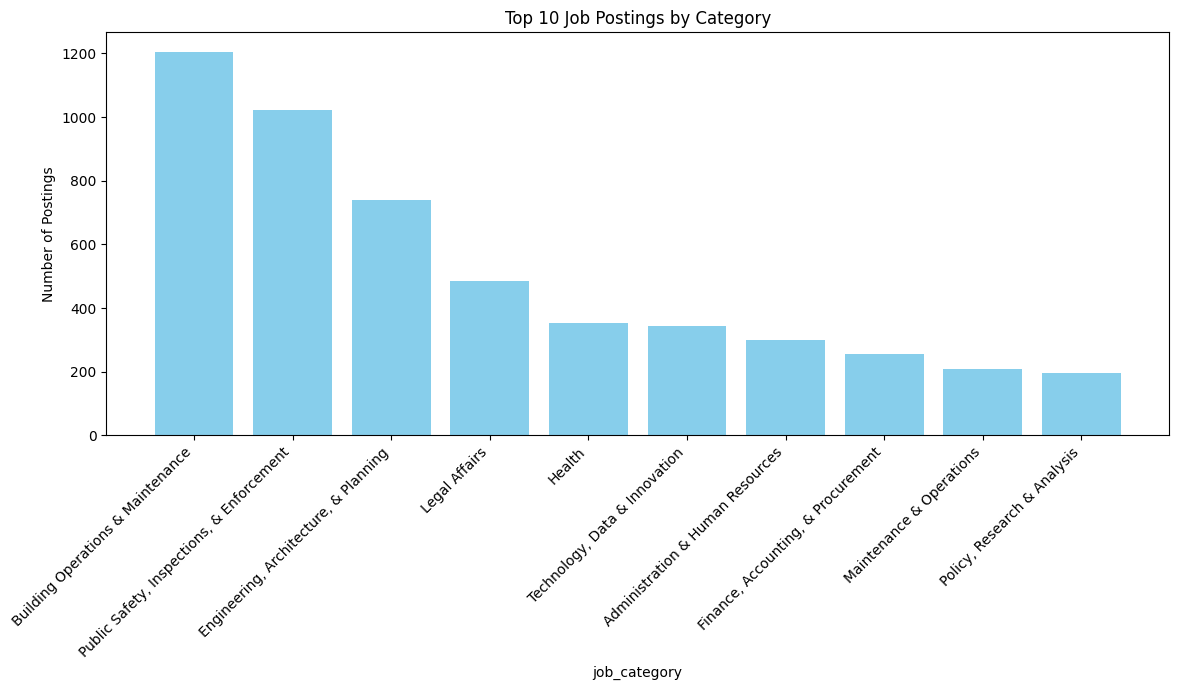

In [64]:
#Visualization
import matplotlib.pyplot as plt

# 5. Collect the results to a Pandas DataFrame for visualization
top_10_categories_pd = top_10_category_df.toPandas()

# 6-9. Create a bar chart for the top 10 job categories
plt.figure(figsize=(12, 7))
plt.bar(top_10_categories_pd['job_category'], top_10_categories_pd['job_count'], color='skyblue')
plt.xlabel('job_category')
plt.ylabel('Number of Postings')
plt.title('Top 10 Job Postings by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### KPI 2 : salary distribution per job category

In [76]:
def kpi_salary_distribution(df):
    df_salary_distribution=df.groupBy('job_category').agg(
                    avg('normalized_annual_salary').alias('average_annual_salary'),
                    min('normalized_annual_salary').alias('min_annual_salary'),
                    max('normalized_annual_salary').alias('max_annual_salary')
                ).orderBy(col('average_annual_salary').desc()).limit(10)
    df_salary_distribution.show()
    
    return df_salary_distribution

In [77]:
kpi2 = kpi_salary_distribution(df)
kpi2.write.mode("overwrite").parquet("C:\\Users\\sakumarchoudhary\\github\\data_engineering_takehome1\\target\\kpi2")

+--------------------+---------------------+------------------+------------------+
|        job_category|average_annual_salary| min_annual_salary| max_annual_salary|
+--------------------+---------------------+------------------+------------------+
|Administration & ...|             218587.0|          218587.0|          218587.0|
|Engineering, Arch...|             198518.0|          198518.0|          198518.0|
|Engineering, Arch...|             196042.5|          182500.0|          209585.0|
|Health Policy, Re...|             128694.5|           94889.0|          162500.0|
|Engineering, Arch...|             128247.5|          128247.5|          128247.5|
|Engineering, Arch...|             128247.5|          128247.5|          128247.5|
|Constituent Servi...|             125280.4|           58500.0|          217201.0|
|Communications & ...|             125000.0|          125000.0|          125000.0|
|Constituent Servi...|   122182.31999999999|122182.31999999999|122182.31999999999|
|Adm

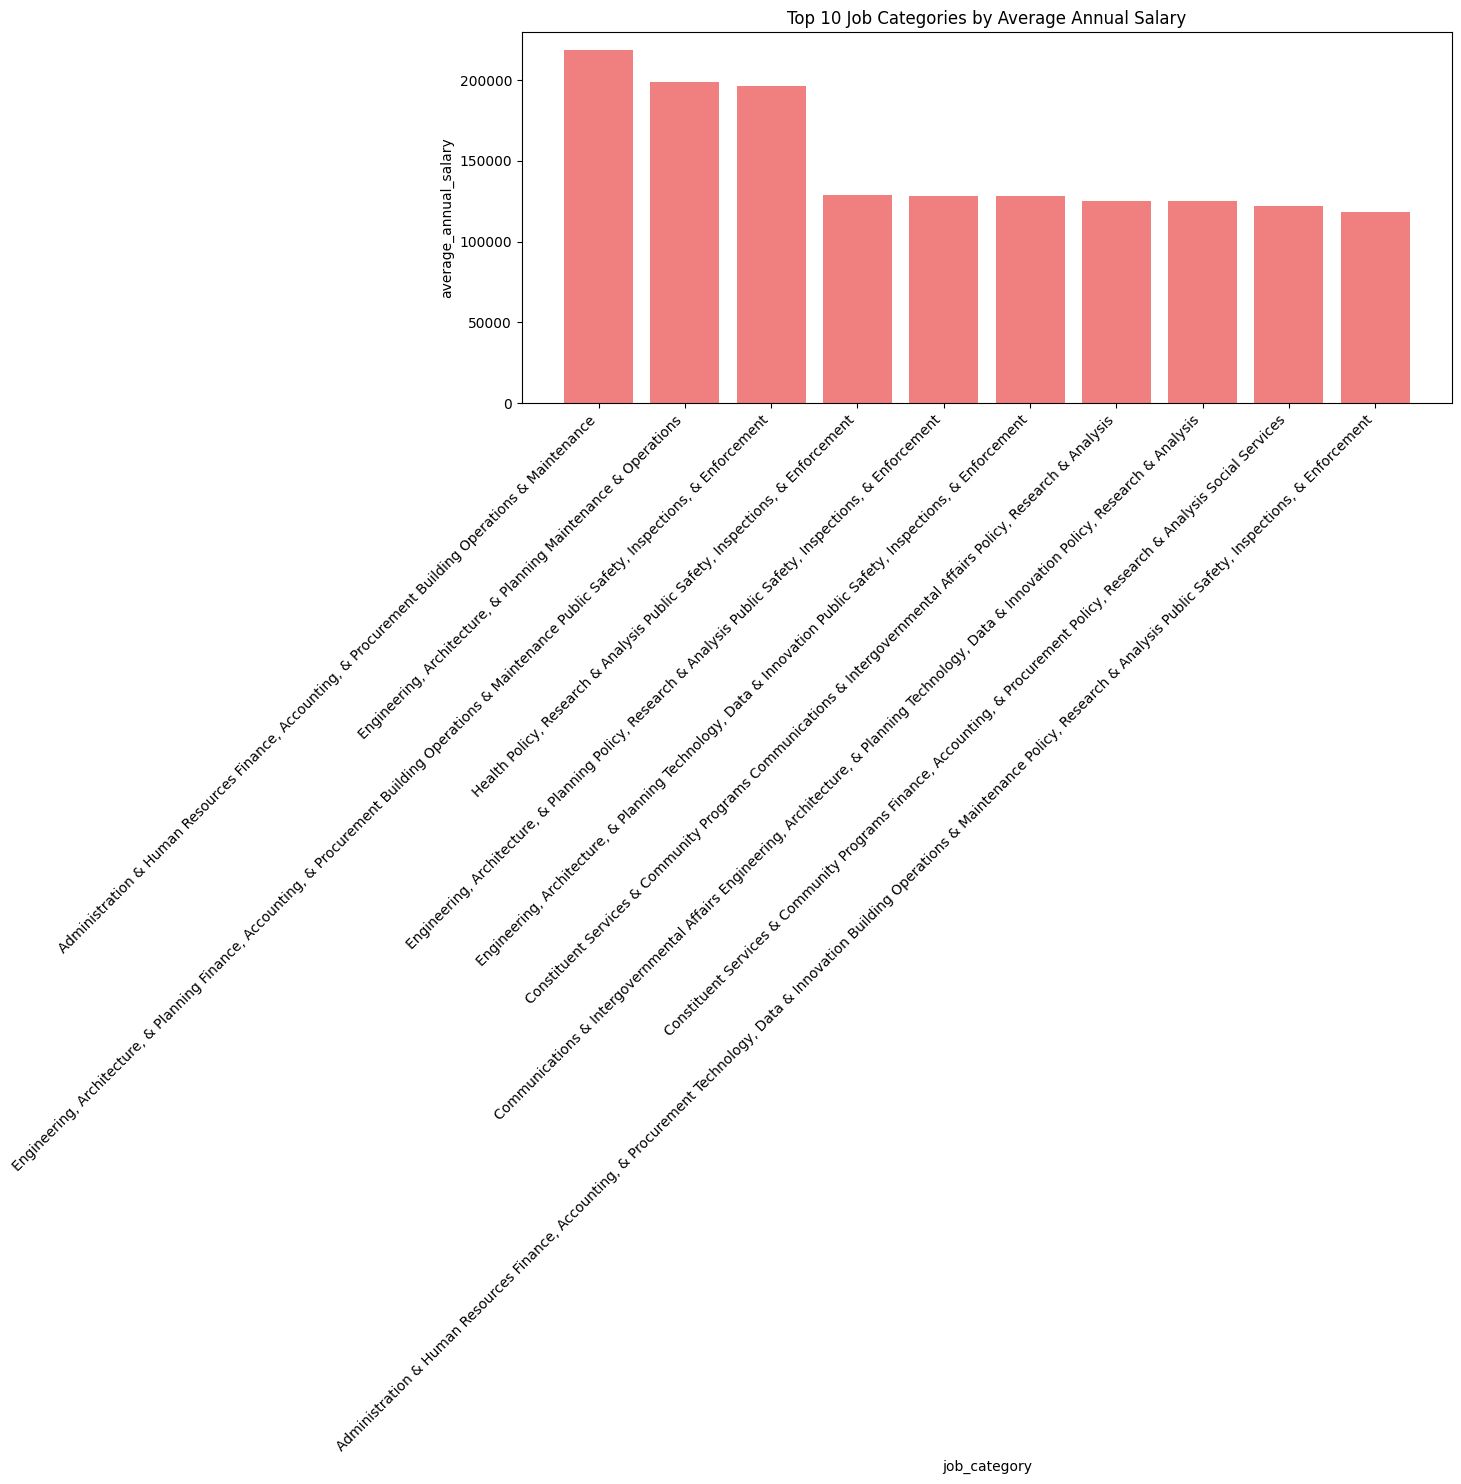

In [72]:
salary_stats_pd = kpi2.toPandas()

# 6-10. Create a bar chart for the top 10 job categories by average annual salary
plt.figure(figsize=(12, 7))
plt.bar(salary_stats_pd['job_category'], salary_stats_pd['average_annual_salary'], color='lightcoral')
plt.xlabel('job_category')
plt.ylabel('average_annual_salary')
plt.title('Top 10 Job Categories by Average Annual Salary')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.35)
plt.show()

## KPI3: correlation between the higher degree and the salary

In [104]:
def kpi_correlation(df):
    df_encoded = df.withColumn(
        "education_numeric",
        when(col("education_level") == "High School/GED", 1)
        .when(col("education_level") == "Associate", 2)
        .when(col("education_level") == "Bachelor", 3)
        .when(col("education_level") == "Master", 4)
        .when(col("education_level") == "PhD", 5)
        .otherwise(None)
        .cast(IntegerType())
    )

    # 2️⃣ Remove rows with null values
    df_clean = df_encoded.filter(
        col("education_numeric").isNotNull() &
        col("normalized_annual_salary").isNotNull()
    )

    avg_salary_df = df_clean.groupBy("education_numeric").agg(avg("normalized_annual_salary")).orderBy("education_numeric")


    # 3️⃣ Calculate Pearson Correlation
    correlation_value = df_clean.stat.corr(
        "education_numeric",
        "normalized_annual_salary"
    )

    print("Correlation between Higher Degree and Salary:", correlation_value)

    # 4️⃣ Optional: Interpretation
    if correlation_value is not None:
        if correlation_value > 0.7:
            print("Strong positive correlation.")
        elif correlation_value > 0.3:
            print("Moderate positive correlation.")
        elif correlation_value > 0:
            print("Weak positive correlation.")
        elif correlation_value < 0:
            print("Negative correlation.")
        else:
            print("No correlation.")
    else:
        print("Correlation could not be calculated.")

    return  avg_salary_df

In [105]:
kpi3=kpi_correlation(df)
kpi3.write.mode("overwrite").parquet("C:\\Users\\sakumarchoudhary\\github\\data_engineering_takehome1\\target\\kpi3")

Correlation between Higher Degree and Salary: 0.413877070596267
Moderate positive correlation.


In [102]:
# kpi3.show()

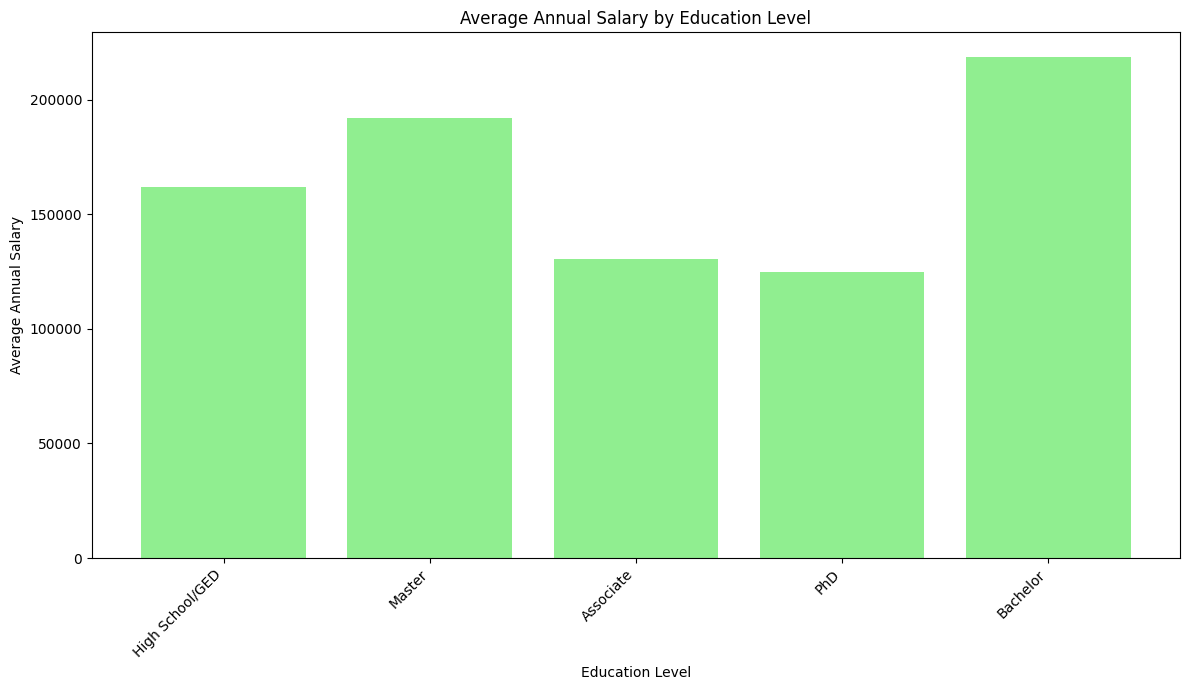

In [95]:
# 5. Convert the results to a Pandas DataFrame for visualization
education_salary_pd = kpi3.toPandas()

# 6-9. Create a bar chart for average annual salary by education level
plt.figure(figsize=(12, 7))
plt.bar(education_salary_pd['education_level'], education_salary_pd['normalized_annual_salary'], color='lightgreen')
plt.xlabel('Education Level')
plt.ylabel('Average Annual Salary')
plt.title('Average Annual Salary by Education Level')
plt.xticks(rotation=45, ha='right')

# 10. Use plt.tight_layout() to ensure all elements fit within the figure, and display the plot
plt.tight_layout()
plt.show()

## KPI 4:  job posting having the highest salary per agency

In [112]:
def kpi_highest_salary_per_agency(df):
    # Define a window specification partitioned by 'Agency' and ordered by 'normalized_annual_salary' in descending order
    # Adding 'Job ID' to the order by clause for deterministic tie-breaking if multiple jobs have the exact same highest salary
    window_spec = Window.partitionBy('agency').orderBy(col('normalized_annual_salary').desc(), col('job_id').asc())
    
    # Apply the row_number window function to assign a rank to each job within its agency
    df_ranked = df.withColumn('rank', row_number().over(window_spec))
    
    # Filter to get only the highest-paying job (rank 1) for each agency
    highest_salary_per_agency = df_ranked.filter(col('rank') == 1)
    
    # Select relevant columns and display the top 10 highest-paying job postings per agency
    highest_salary_per_agency=highest_salary_per_agency.orderBy(desc('normalized_annual_salary')) \
                             .select('agency', 'business_title', 'normalized_annual_salary', 'job_id')

    return highest_salary_per_agency

In [114]:
kpi4=kpi_highest_salary_per_agency(df)
kpi4.write.mode("overwrite").parquet("C:\\Users\\sakumarchoudhary\\github\\data_engineering_takehome1\\target\\kpi4")

In [116]:
kpi4.printSchema()

root
 |-- agency: string (nullable = true)
 |-- business_title: string (nullable = true)
 |-- normalized_annual_salary: double (nullable = true)
 |-- job_id: integer (nullable = true)



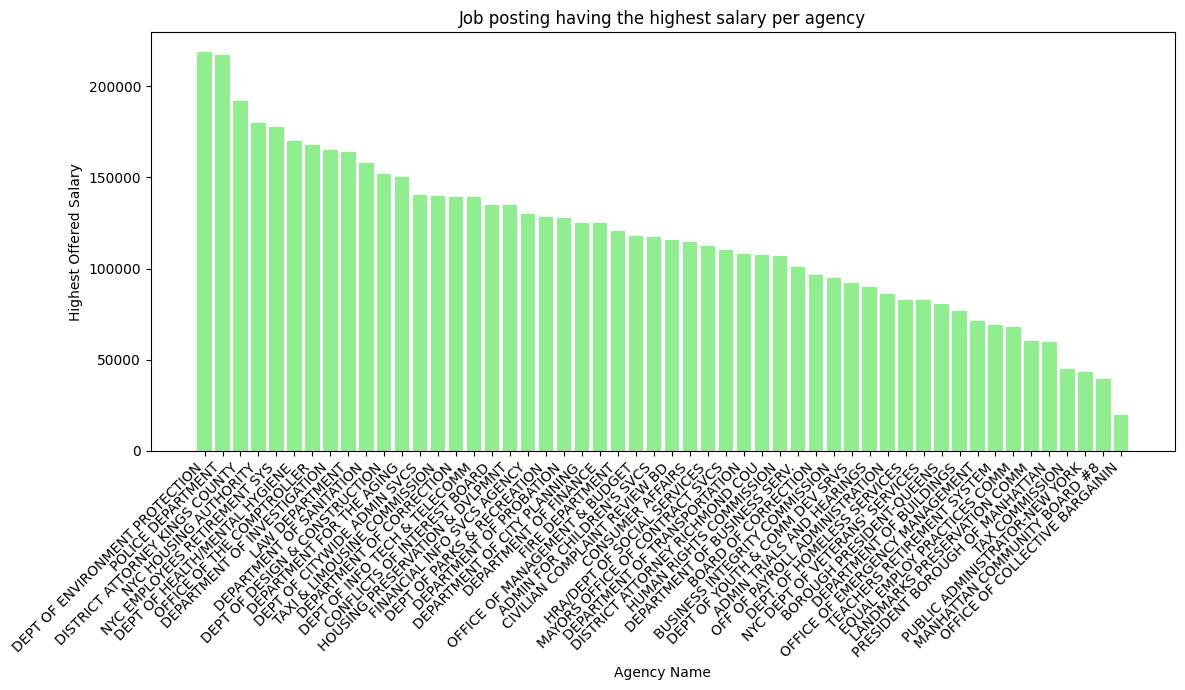

In [117]:
agency_highest_salary_pd = kpi4.toPandas()

# 6-9. Create a bar chart for average annual salary by education level
plt.figure(figsize=(12, 7))
plt.bar(agency_highest_salary_pd['agency'], agency_highest_salary_pd['normalized_annual_salary'], color='lightgreen')
plt.xlabel('Agency Name')
plt.ylabel('Highest Offered Salary')
plt.title('Job posting having the highest salary per agency')
plt.xticks(rotation=45, ha='right')

# 10. Use plt.tight_layout() to ensure all elements fit within the figure, and display the plot
plt.tight_layout()
plt.show()

## KPI 5: job postings average salary per agency for the last 2 years

In [125]:
def kpi_salary_last_two_years(df):
    df_date = df.withColumn(
        'posting_date',
        to_date(try_to_timestamp(col('posting_date'), lit('yyyy-MM-dd')))
    )
    
    # Filter out rows where 'Posting Date' conversion resulted in null
    df_date_cleaned = df_date.filter(col('posting_date').isNotNull())
    
    # 2. Determine the maximum 'Posting Date' from the cleaned DataFrame
    #    Handle case where max_posting_date_value might be None if df_date_cleaned was empty
    max_posting_date_value = df_date_cleaned.agg(max('posting_date')).collect()[0][0]
    
    # Convert max_posting_date_value to a PySpark date literal
    if max_posting_date_value is None:
        # Fallback to current date if no valid posting dates are found
        max_date_literal = current_date()
    else:
        max_date_literal = lit(max_posting_date_value)
    
    
    two_years_ago = date_sub(max_date_literal, 365 * 2) # Approximately 2 years
    
    print(f"Maximum Posting Date: {max_posting_date_value}")
    print(f"Date two years prior: {two_years_ago}")
    
    # 3. Filter the DataFrame to include only job postings within the 'last two years' period
    df_recent = df_date_cleaned.filter(col('Posting Date') >= two_years_ago)

    average_salary_per_agency = df_recent.groupBy('agency').agg(
        avg('normalized_annual_salary').alias('average_salary_offered_in_last_two_years')
    ).orderBy(col('average_salary_offered_in_last_two_years').desc())

    return average_salary_per_agency


In [128]:
kpi5=kpi_salary_last_two_years(df)
kpi5.write.mode("overwrite").parquet("C:\\Users\\sakumarchoudhary\\github\\data_engineering_takehome1\\target\\kpi5")

Maximum Posting Date: 2019-12-17
Date two years prior: Column<'date_sub(DATE '2019-12-17', 730)'>


In [127]:
kpi5.show(truncate=False)

+------------------------------+----------------------------------------+
|agency                        |average_salary_offered_in_last_two_years|
+------------------------------+----------------------------------------+
|CONFLICTS OF INTEREST BOARD   |135000.0                                |
|NYC EMPLOYEES RETIREMENT SYS  |98336.02777777778                       |
|BOARD OF CORRECTION           |96222.5                                 |
|FINANCIAL INFO SVCS AGENCY    |93332.93103448275                       |
|DEPARTMENT OF SANITATION      |93168.31999999999                       |
|NYC HOUSING AUTHORITY         |90597.54033149169                       |
|DEPT OF DESIGN & CONSTRUCTION |87763.06060606061                       |
|LAW DEPARTMENT                |87731.6372121212                        |
|MAYORS OFFICE OF CONTRACT SVCS|87357.14285714286                       |
|DEPT OF INFO TECH & TELECOMM  |86794.95                                |
|FIRE DEPARTMENT               |86483.

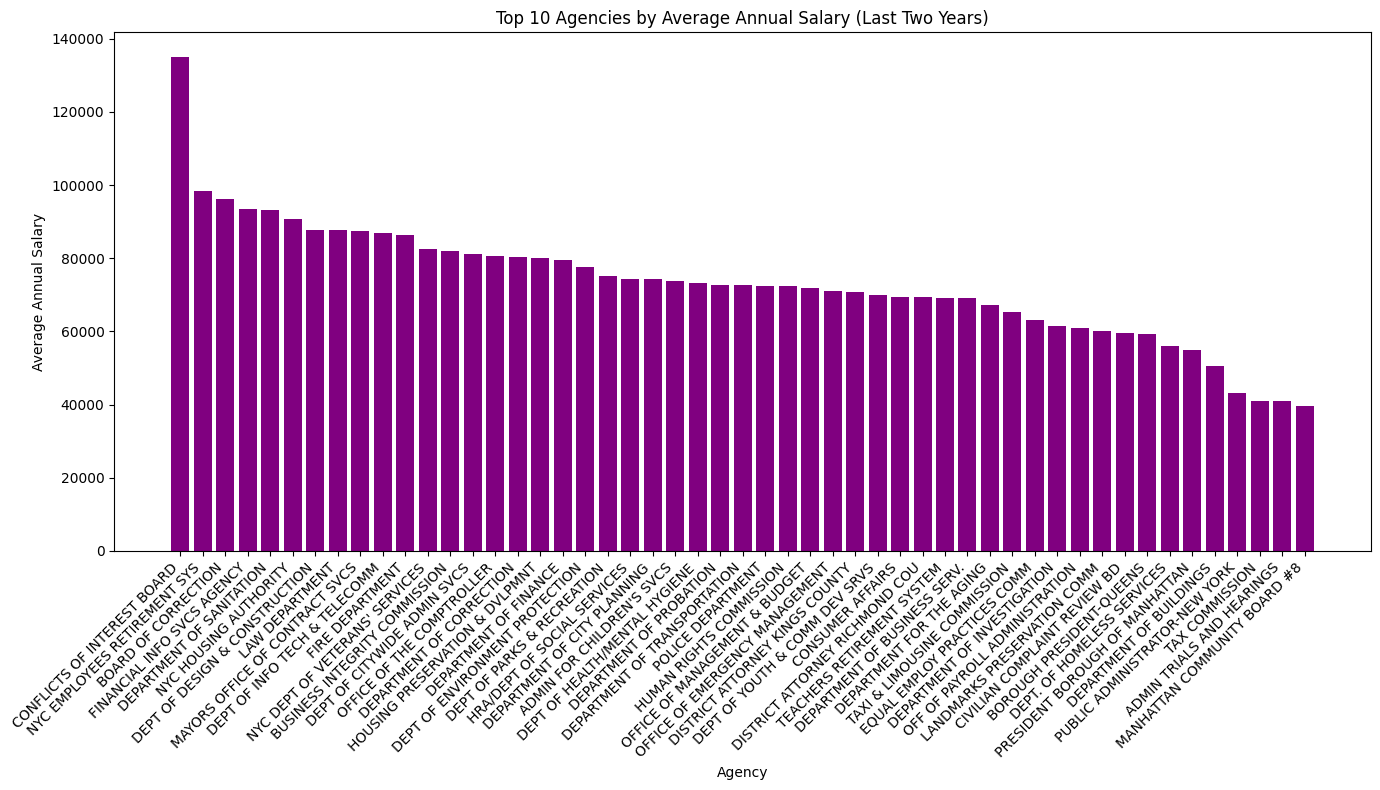

In [132]:
average_salary_per_agency_pd = kpi5.toPandas()

# 8. Create a bar chart showing the average salary for the top 10 agencies
plt.figure(figsize=(14, 8))
plt.bar(average_salary_per_agency_pd['agency'], average_salary_per_agency_pd['average_salary_offered_in_last_two_years'], color='purple')
plt.xlabel('Agency')
plt.ylabel('Average Annual Salary')
plt.title('Top 10 Agencies by Average Annual Salary (Last Two Years)')

# 9. Rotate the x-axis labels by 45 degrees for readability and adjust the plot layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## KPI6: highest paid skills in the US market

In [171]:
def kpi_highest_paid_skill(df):

    # Filter valid salary rows
    df_clean = df.filter(col("normalized_annual_salary").isNotNull())

    # Calculate average salary per skill in a single aggregation
    agg_df = df_clean.groupBy().agg(
        avg(when(col("has_python") == 1,
                 col("normalized_annual_salary"))).alias("Python"),
        avg(when(col("has_sql") == 1,
                 col("normalized_annual_salary"))).alias("SQL"),
        avg(when(col("has_cloud") == 1,
                 col("normalized_annual_salary"))).alias("Cloud")
    )

    python_df = agg_df.select(
        lit("Python").alias("skill"),
        col("Python").alias("avg_salary")
    )

    sql_df = agg_df.select(
        lit("SQL").alias("skill"),
        col("SQL").alias("avg_salary")
    )

    cloud_df = agg_df.select(
        lit("Cloud").alias("skill"),
        col("Cloud").alias("avg_salary")
    )

    result_df = python_df.union(sql_df).union(cloud_df) \
        .orderBy(col("avg_salary").desc())

    # Return highest paid skill
    return result_df.limit(1)

In [172]:
kpi6=kpi_highest_paid_skill(df)
kpi6.write.mode("overwrite").parquet("C:\\Users\\sakumarchoudhary\\github\\data_engineering_takehome1\\target\\kpi6")

In [173]:
kpi5.show()

+-----+-----------------+
|skill|       avg_salary|
+-----+-----------------+
|Cloud|99346.56976744186|
+-----+-----------------+



In [156]:
# df.printSchema()

In [138]:
df.filter(col('has_sql')==1).count()

188

In [48]:
def get_salary_frequency(df: DataFrame) -> list:
    row_list = df.select('Salary Frequency').distinct().collect()
    return [row['Salary Frequency'] for row in row_list]

### Example of test function

In [65]:
mock_data = [('A', 'Annual'), ('B', 'Daily')]
expected_result = ['Annual', 'Daily']

In [66]:
def test_get_salary_frequency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['id', 'Salary Frequency']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert get_salary_frequency(mock_df) == expected_result

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, lit
import unittest

# Assuming spark session is already created as 'spark'
# For testing purposes, we can create a local SparkSession
spark = SparkSession.builder \
    .appName("UnitTest") \
    .master("local[*]") \
    .getOrCreate()

class TestKpiHighestPaidSkill(unittest.TestCase):

    def test_highest_paid_skill_basic(self):
        # Mock data
        data = [
            (1, 100000, 1, 0, 0), # Python
            (2, 120000, 0, 1, 0), # SQL
            (3, 110000, 0, 0, 1), # Cloud
            (4, 130000, 1, 1, 0), # Python, SQL
            (5, 150000, 0, 1, 1), # SQL, Cloud
            (6, 90000, 1, 0, 1),  # Python, Cloud
            (7, None, 1, 1, 1),   # Null salary
            (8, 100000, 0, 0, 0)  # No skill
        ]
        columns = ["id", "normalized_annual_salary", "has_python", "has_sql", "has_cloud"]
        df = spark.createDataFrame(data, columns)

        # Call the function under test
        result_df = kpi_highest_paid_skill(df)

        # Expected result: Calculate average manually for verification
        # Python: (100000 + 130000 + 90000) / 3 = 106666.66
        # SQL: (120000 + 130000 + 150000) / 3 = 133333.33
        # Cloud: (110000 + 150000 + 90000) / 3 = 116666.66
        
        expected_data = [("SQL", 133333.33333333334)]
        expected_df = spark.createDataFrame(expected_data, ["skill", "avg_salary"])

        # Assert the result
        self.assertEqual(result_df.count(), 1)
        self.assertEqual(result_df.collect()[0].skill, "SQL")
        self.assertAlmostEqual(result_df.collect()[0].avg_salary, expected_df.collect()[0].avg_salary)

# Run the test
suite = unittest.TestSuite()
suite.addTest(unittest.makeSuite(TestKpiHighestPaidSkill))
runner = unittest.TextTestRunner()
runner.run(suite)

# Stop the SparkSession after tests
spark.stop()